In [2]:
import torch
from d2l import torch as d2l

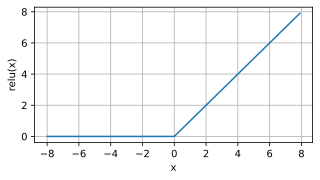

In [3]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

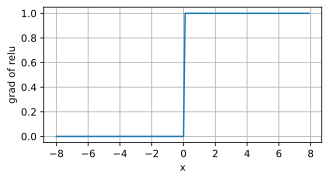

In [4]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

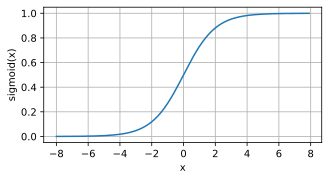

In [5]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

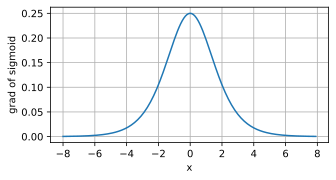

In [6]:
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

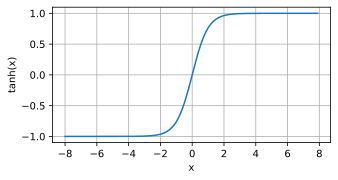

In [7]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

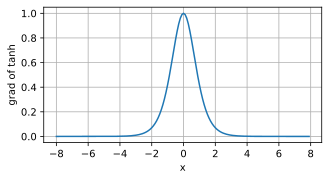

In [8]:
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

In [10]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [11]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
params = [W1, b1, W2, b2]

In [12]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [13]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1) # '@' 代表矩阵乘法
    return (H@W2 + b2)

In [14]:
loss = nn.CrossEntropyLoss()

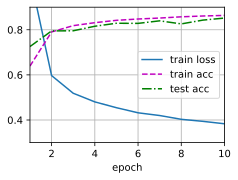

In [15]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

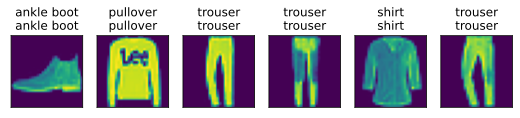

In [16]:
d2l.predict_ch3(net, test_iter)

In [17]:
import torch
from torch import nn
from d2l import torch as d2l

In [18]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [19]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

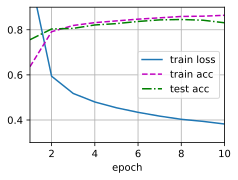

In [20]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [21]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [22]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0: 4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) # poly_features.shape: 200 * 20
# features: 200 * 1, 后面那个式子: 1 * 20
# 两个都会广播成 200 * 20
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n) = (n-1)!
labels = np.dot(poly_features, true_w) # shape: 200
labels += np.random.normal(scale=0.1, size=labels.shape) # 噪声

In [23]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=d2l.float32) for x in [true_w, features, poly_features, labels]]

In [24]:
features[: 2], poly_features[: 2, :], labels[: 2]

(tensor([[-0.1971],
         [ 0.9831]]),
 tensor([[ 1.0000e+00, -1.9714e-01,  1.9432e-02, -1.2770e-03,  6.2935e-05,
          -2.4814e-06,  8.1530e-08, -2.2961e-09,  5.6582e-11, -1.2394e-12,
           2.4434e-14, -4.3790e-16,  7.1939e-18, -1.0909e-19,  1.5362e-21,
          -2.0190e-23,  2.4876e-25, -2.8848e-27,  3.1595e-29, -3.2782e-31],
         [ 1.0000e+00,  9.8311e-01,  4.8326e-01,  1.5836e-01,  3.8923e-02,
           7.6531e-03,  1.2540e-03,  1.7611e-04,  2.1642e-05,  2.3641e-06,
           2.3242e-07,  2.0772e-08,  1.7018e-09,  1.2869e-10,  9.0373e-12,
           5.9231e-13,  3.6394e-14,  2.1047e-15,  1.1495e-16,  5.9479e-18]]),
 tensor([4.7930, 5.4680]))

In [25]:
def evaluate_loss(net, data_iter, loss):
    ''' 评估给定数据集上模型的损失'''
    metric = d2l.Accumulator(2) # 损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l * len(out), l.numel())
    return metric[0] / metric[1]

In [26]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-2, 1e3], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
            
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.003949   1.17798   -3.4176092  5.6032686]]


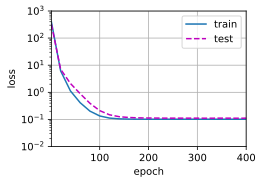

In [27]:
train(poly_features[: n_train, : 4], poly_features[n_train:, : 4], labels[: n_train], labels[n_train: ])

weight: [[3.5264356 6.2408895]]


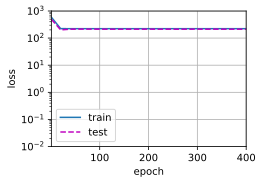

In [28]:
train(poly_features[: n_train, : 2], poly_features[n_train:, : 2], labels[: n_train], labels[n_train: ])

weight: [[ 4.9741535   1.3449193  -3.255811    4.865487   -0.31235555  1.490965
   0.23944445  0.04157046  0.00841584  0.18586063 -0.11206017  0.03592322
   0.07630708  0.1456364  -0.19218723  0.14475234  0.15243426 -0.01294658
  -0.0331352   0.07483605]]


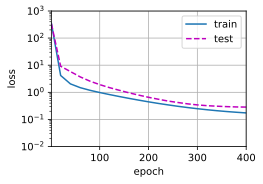

In [29]:
train(poly_features[: n_train, :], poly_features[n_train:, :], labels[: n_train], labels[n_train: ])

In [30]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [31]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [32]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [33]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [34]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.8762788772583


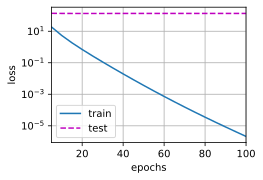

In [35]:
train(lambd=0)

w的L2范数是： 0.022504184395074844


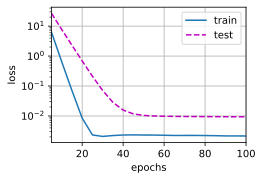

In [36]:
train(lambd=10)

In [37]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {'params': net[0].weight, 'weight_decay': wd},
        {'params': net[0].bias}
    ], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', net[0].weight.norm().item())

w的L2范数是： 12.472065925598145


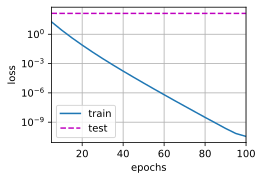

In [38]:
train_concise(0)

w的L2范数是： 0.02179323136806488


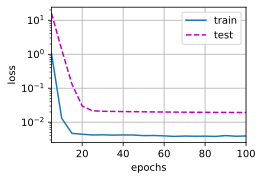

In [39]:
train_concise(20)

In [40]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    return mask * X / (1.0 - dropout)

In [41]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  6.,  8.,  0.,  0., 14.],
        [ 0., 18., 20.,  0., 24., 26., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [42]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [43]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模式才使用 dropout
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out
    
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

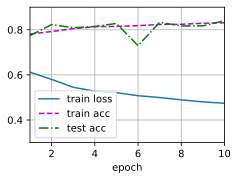

In [45]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [46]:
net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(256, 10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

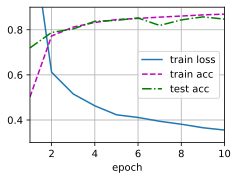

In [47]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

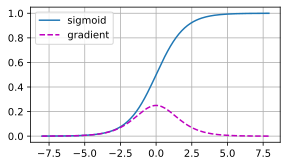

In [48]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
        legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [49]:
M = torch.normal(0, 1, size=(4, 4))
print('一个矩阵 \n', M)
for i in range(100):
    A = torch.normal(0, 1, size=(4, 4))
    M = torch.mm(M, A)
print('乘以100个矩阵后 \n', M)

一个矩阵 
 tensor([[-0.4544, -0.4806,  0.2478, -0.8247],
        [-1.0497,  0.9597, -0.3844,  0.4044],
        [ 1.6303,  1.4922, -0.2510,  0.1944],
        [-0.1952,  0.5921,  1.4124, -2.0842]])
乘以100个矩阵后 
 tensor([[ 8.5283e+22, -1.0542e+23, -2.6509e+23,  4.2937e+22],
        [-2.2737e+23,  2.8105e+23,  7.0677e+23, -1.1448e+23],
        [-1.8296e+23,  2.2615e+23,  5.6871e+23, -9.2115e+22],
        [-2.0438e+23,  2.5263e+23,  6.3530e+23, -1.0290e+23]])


In [50]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [51]:
def download(name, cache_dir=os.path.join('..', 'data')):
    '''下载一个 DATA_HUB 中的文件，返回本地文件名'''
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [52]:
def download_extract(name, folder=None):
    '''下载并解压zip/tar文件'''
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    '''下载DATA_HUB中的所有文件'''
    for name in DATA_HUB:
        download(name)

In [53]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [54]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [55]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...


In [56]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [57]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [58]:
all_features = pd.concat((train_data.iloc[:, 1: -1], test_data.iloc[:, 1:]))

In [59]:
all_features.shape

(2919, 79)

In [66]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index # 每列的索引
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化后，所有数据的均值为 0，所以可以将缺失值设为 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [72]:
# `Dummy_na=True` 将 'na' 视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [75]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=d2l.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=d2l.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32)

In [80]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [82]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于 1 的值设置为 1
    # torch.clamp() 将输入t张量每个元素的范围限制到区间 [min,max]
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [83]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [84]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [90]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, 
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i+1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.170051, valid log rmse 0.156598
fold 2, train log rmse 0.162059, valid log rmse 0.190090
fold 3, train log rmse 0.164616, valid log rmse 0.168833
fold 4, train log rmse 0.167856, valid log rmse 0.154637
fold 5, train log rmse 0.163550, valid log rmse 0.182950
5-折验证：平均训练log rmse: 0.165626, 平均验证log rmse: 0.170622


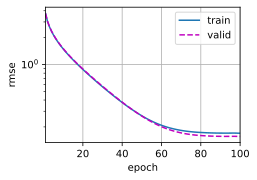

In [91]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [105]:
def train_and_pred(train_features, test_features, train_labels, test_data, 
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集
    preds = net(test_features).detach().numpy() # 列向量
    # 将其重新格式化以导出到 Kaggle
    #test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0]) # 转换为单行矩阵后提取为行向量
    test_data['SalePrice'] = pd.Series(preds.reshape(-1)) # 必须要行向量
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162354
(1459, 1)


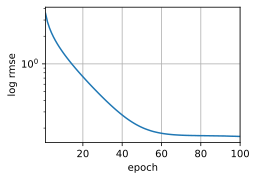

In [106]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [104]:
a = np.arange(1, 20)
a.shape

(19,)

In [99]:
a.reshape(1, -1)

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]])

In [98]:
pd.Series(a.reshape(1, -1)[0])

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
dtype: int32